In [1]:
import pandas as pd
import numpy as np
import os
import re
import glob

from tqdm.notebook import tqdm

# Считывание всех данных

In [2]:
def ReadToDf(folder: str):
    df = pd.DataFrame(columns=['univ', 'prog', 'name', 'text'])
    for file in tqdm(glob.glob('{}/*/*/*.txt'.format(folder))):
        splitted = file.split('\\')
        name = splitted[-1][:-4]
        u = splitted[-3]
        op = splitted[-2]
        
        try:
            text = open(file, 'r').read()
        except Exception as e:
            print(e)
            print(file)
            text = open(file, 'r', encoding='utf-8').read()
        
        df = df.append({'univ':u, 'prog':op, 'name':name, 'text':name + ' ' + text.lower()}, ignore_index=True)
    return df

In [3]:
df = ReadToDf('files')

  0%|          | 0/3022 [00:00<?, ?it/s]

# Лемматизация текста
* https://habr.com/ru/post/205360/
* https://russianblogs.com/article/9814548532/

In [4]:
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

a = ord('а')
default_stop = set(stopwords.words('russian') + [chr(i) for i in range(a, a + 32)] + [_ for _ in range(10)])

Лемматизацию текста можно проводить с помощью двух популярных библиотек для русского языка: `pymorphy2` и `pymystem3`. Выбор для данной работы -- `pymystem3`. Основное преимущество: простота использования и контекстная лемматизация.

In [5]:
from pymystem3 import Mystem
ms = Mystem()

regs = [
    r'аннотация', r'\sический\s', r'\sопоп\s',
    r'\sшт\s', r'\sдр\s', r'\sго\s', r'\sита\s', r'\sия\s', r'\sв?ах\s',
    r'\sсей\s', r'\sтий\s', r'\sвать\s', r'\sдея\s',
    r'\ d?\d*?\ ', '0302',
    r'[·•—“”„№¶…>%=’]',
]

def lemmatize(text):
    lemmas = ms.lemmatize(text)
    text = ''.join(lemmas).rstrip('\n')
    for reg in regs:
        text = re.sub(reg, '', text)
    return text

Предыдущая работы была проделана с целью очистки текста так, чтобы фильная обработка включала в себя только удаление лишних слов. Таким образом, были удалены лишние конструкции, такие как, например, "20 часов", "целями дисциплины являются", "основные компетенции" и т. д., удалены знаки пунктуации, кроме дефиса: некоторые важные составные слова могут существенно повлиять на качество модели (SQL-запрос, web-разработка, т. д.).

Для начала удалим все стоп-слова: союзы, предлоги и т. д., затем проведем количественный анализ слов, и из каждого текста удалим определенный процент часто- и редковстречаемых слов.

Решено было удалить и кодировки компетенций, которые изначально планировалось оставить. Такое решение позволило в три раза уменьшить словарь.

In [6]:
import time

comp_regs = [
    r'ОПК[\-\ ]?\d\d?',
    r'ПК[\-\ ]?\d\d?',
    r'УК[\-\ ]?\d\d?',
    r'ОК[\-\ ]?\d\d?',
    r'ИДЫ[\-\ ]?\d\d?',
    r'ИДК[\-\ ]?\d\d?',
]

def process_text(text, f_lemmatizer=lemmatize, wstop=default_stop, counter=None):
    if f_lemmatizer is not None:
        text = f_lemmatizer(text)
    
    for reg in comp_regs:
        text = re.sub(reg, '', text, flags=re.IGNORECASE)
              
    text = [word for word in word_tokenize(text) if word not in wstop]
    if counter is not None:
        counter.update(text)
    return ' '.join(text)

fd_counter = FreqDist()

start = time.time()
df.text = df.text.apply(process_text, counter=fd_counter)
print('Time spent: {} s.'.format(time.time() - start))

Time spent: 2701.358400583267 s.


In [7]:
len(fd_counter)

19027

Код выше выполняется около часа, поэтому перепишем результат его работы в json

In [8]:
import json
jsonStr = json.dumps(dict(fd_counter.most_common()), ensure_ascii=False)
file = open('JsonCounter.json', 'w')
file.write(jsonStr)
file.close()

Переписывание файлов

In [9]:
def rewrite(folder: str, df):
    for row in df.iterrows():
        r = row[1]
        filename = folder + '\\' + r['univ'] + '\\' + r['prog'] + '\\' + r['name'] + '.txt'

        file_ = open(filename, 'w', encoding='ansi')
        try:
            file_.write(r['text'])
        except Exception as e:
            print('FATAL:', e)
            print(row[0], filename)
            file_.close() 
            break
        file_.close()

rewrite('files', df)

Если посмотреть на получившийся словарь, то среди редковстречаемых слов можно обнаружить множество выбросов: отрывки слов, необычные символы, и т. д. Проблема заключается в том, что такие слова часто встречаются столько же раз, сколько и семантически важные слова, что может существенно испортить качество кластеризации. Данная проблема возникла из-за несовершенства парсинга, а так же опечаток, допущенных в процессе составления документа авторами.

Чтобы сгладить углы проблемы, удалим те слова, которые начинаются не с буквы: если лексикографически отсортировать получившийся словарь, то легко понять, что первые слова, стоящие до слов, начинающийхся на английскую `a` являются невалидными. Примеры таких слов: 19гfreeware, 25002900лексическихединиц, 14экзаменаци.

Конечно, это не панацея, и опечатки все равно останутся, однако их будет меньше.

In [10]:
corrected_dict = {}
typo_words = []
for item in sorted(fd_counter.items()):
    if not str.isalpha(item[0][0]):
        typo_words.append(item[0])
        continue
    corrected_dict[item[0]] = item[1]
len(corrected_dict)

18723

In [11]:
# jsonStr = open('JsonCounter.json', 'r').read()
# d = json.loads(jsonStr)
d = FreqDist(corrected_dict)
d

FreqDist({'система': 10631, 'метод': 8273, 'задача': 7434, 'навык': 6622, 'основной': 6561, 'информационный': 6452, 'решение': 5816, 'дисциплина': 5802, 'деятельность': 5534, 'программный': 4893, ...})

### Удаление слов
Удалим слова, которые встречаются менее 4 раз и слова, встречающиеся более 2000 раз, а также некоторые контекстные слова и опечатки.

In [12]:
context_stop = ['раздел', 'результат', 'освоение', 'применение', 'использование', 'изучение', 'практика',
    'представление', 'модуль', 'владеть', 'знать', 'уметь', 'применять', 'понятие', 'формирование',
    'создание', 'развитие', 'получать', 'иметь', 'опыт', 'студент', 'изучение', 'структура', 'умение',
    'использовать', 'общий', 'организация', 'опк', 'oпк', 'пк', 'ук', 'ок', 'принцип', 'назначение', 'цель',
    'способный', 'определение', 'построение', 'вид', 'проект', 'особенность', 'стр', 'стp', 'cтp', 'кoд',
    'б1', 'выпускник', 'иной', 'развивать', 'текущий', 'важный', 'ечас', 'позволять',  'направление',
    'бакалавр', 'лекция', 'находить', 'понимать', 'иметься', 'обладать', 'тема', 'ых', 'ый', 'подготовка',
    'самостоятельно', 'профиль', 'научать', 'специалист', 'иса', 'ита', 'осваивать', 'выпускной',
    'общепрофессиональный', 'a', 'разный', 'решать', 'июль', 'ока', 'oка', 'окa', 'квалификационный',
    'осуществление', 'первый', 'второй', 'третий', 'четвертый', 'пятый',  'комп', 'тенция', 'граммный',
    'отчет', 'весь', 'контрольный', 'овладение', 'самостоятельный', 'зачетный', 'единица',
    'давать', 'работать', 'выбирать', 'свой', 'курс', 'формировать','произ', 'водство', 'шение',
    'зад', 'ние', 'информ', 'ин', 'ровать', 'ного', 'ре', 'пoмещение', 'помещениe', 'наименование', 'также', 
]

words_most = []
words_least = []
most = 2000
least = 4
for w in d.keys():
    if d[w] >= most:
        words_most.append(w)
    elif d[w] <= least:
        words_least.append(w)

upd_wstop = set(words_most + words_least + typo_words + context_stop)
len(upd_wstop)

12499

In [13]:
fd_counter_trunc = FreqDist()
df_trunc = df.copy()

start = time.time()
df_trunc.text = df_trunc.text.apply(process_text, f_lemmatizer=None, wstop=upd_wstop, counter=fd_counter_trunc)
print('Time spent: {} s.'.format(time.time() - start))

Time spent: 3.6927285194396973 s.


In [14]:
len(list(dict(fd_counter_trunc)))

6538

In [15]:
jsonStr_trunc = json.dumps(dict(fd_counter_trunc.most_common()), ensure_ascii=False)
file = open('JsonCounter_trunc.json', 'w')
file.write(jsonStr_trunc)
file.close()

In [16]:
rewrite('files', df_trunc)

Удалим дубликаты.

In [17]:
# df_trunc = ReadToDf('files')
df_trunc.drop_duplicates(subset='text', inplace=True)
len(df_trunc)

2559

### LDA (Latent Dirichlet allocation)
Помимо кластеризации также рассмотрим метод `LDA`  для тематического моделирования. Выведем облака тегов, чтобы оценить результат работы с данными.

In [18]:
%load_ext autoreload

In [56]:
%autoreload 2
from hyperparameters import lda_kwargs
from visualization import draw_wordcloud, draw_cluster_clouds
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer().fit(df_trunc.text.values)
bow = vectorizer.transform(df_trunc.text.values)

lda = LDA(**lda_kwargs, n_jobs=-1).fit(bow)
labels_lda = np.argmax(lda.transform(bow), axis=1)
n_clusters = 16

cluster: 1


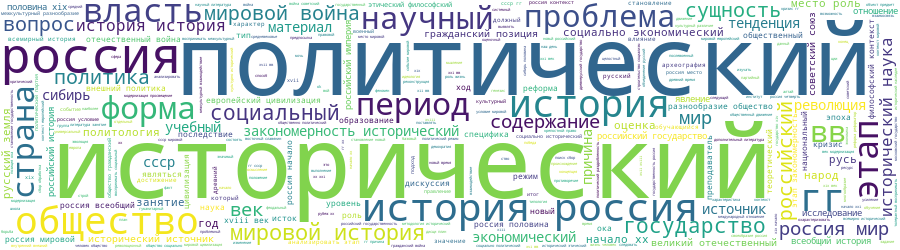

cluster: 2


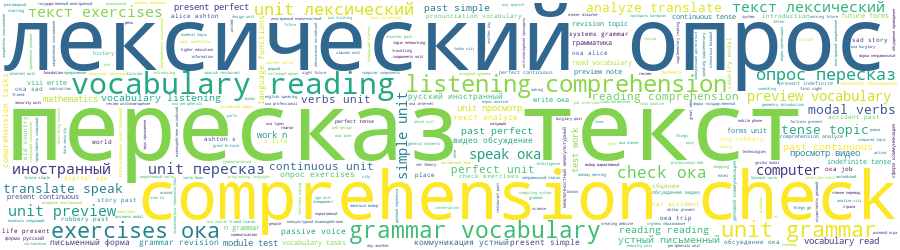

cluster: 3


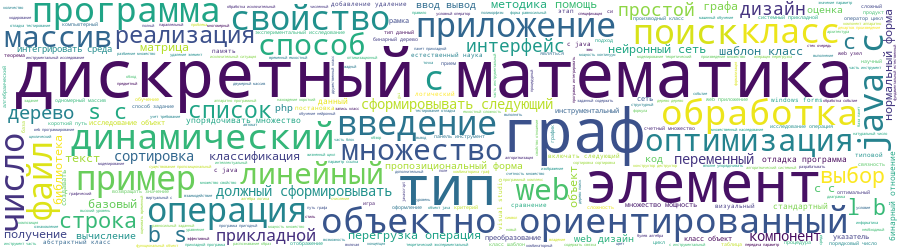

cluster: 4


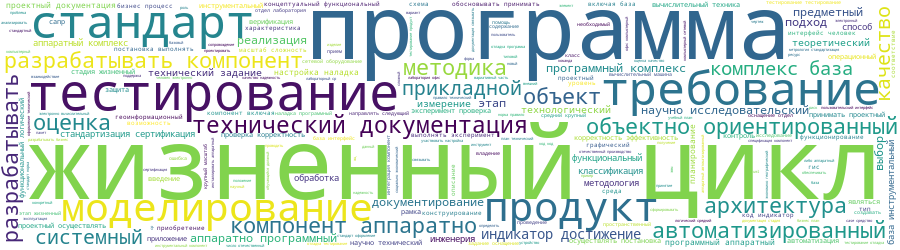

cluster: 5


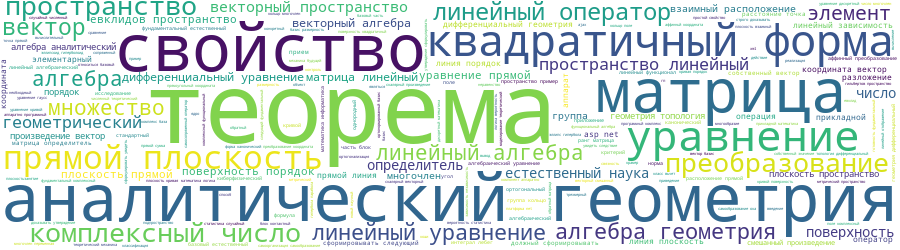

cluster: 6


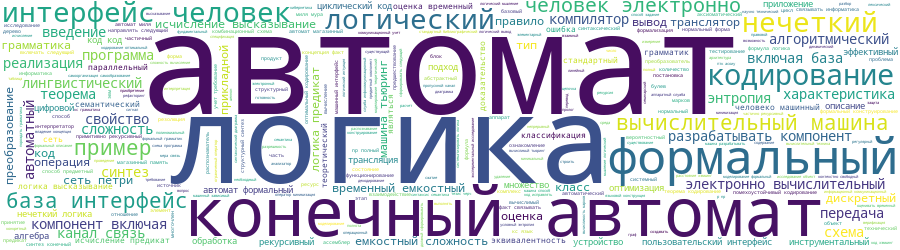

cluster: 7


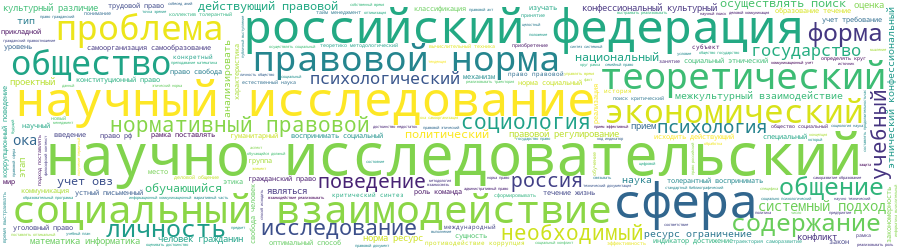

cluster: 8


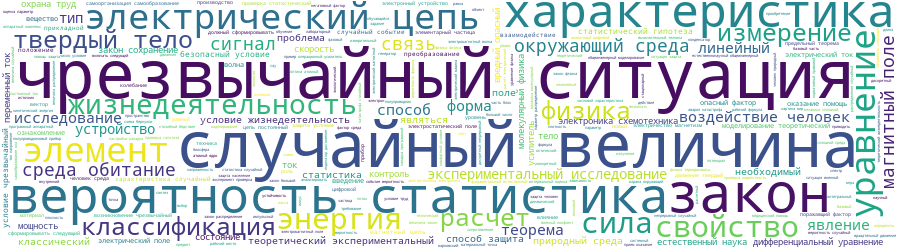

cluster: 9


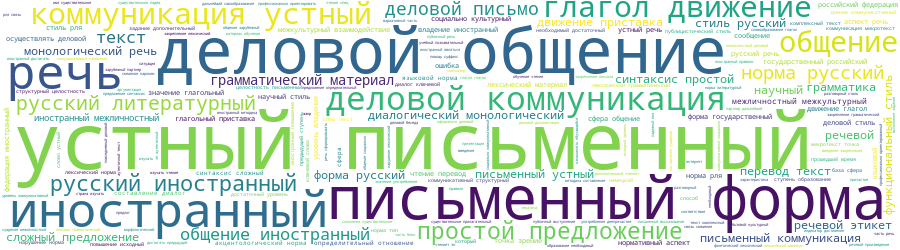

cluster: 10


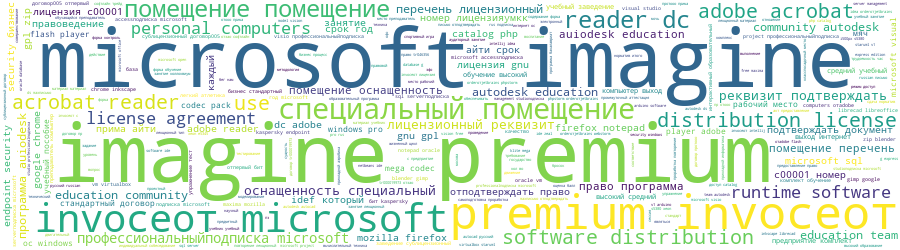

cluster: 11


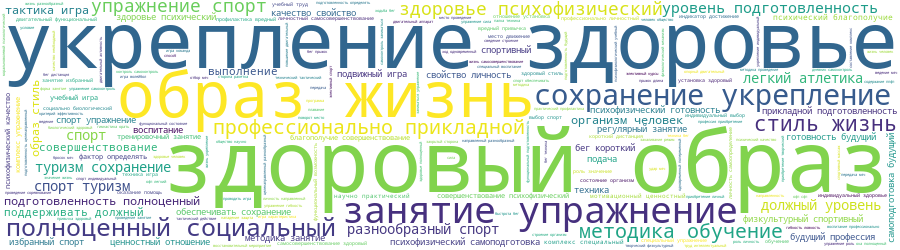

cluster: 12


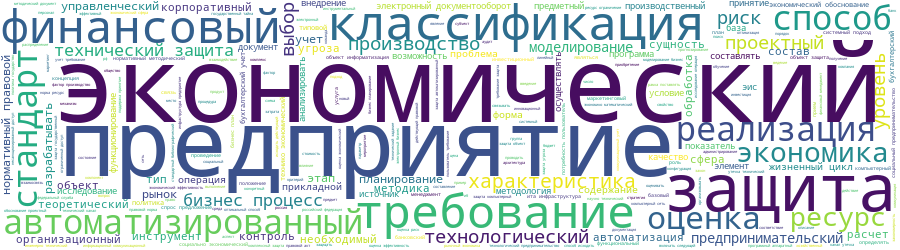

cluster: 13


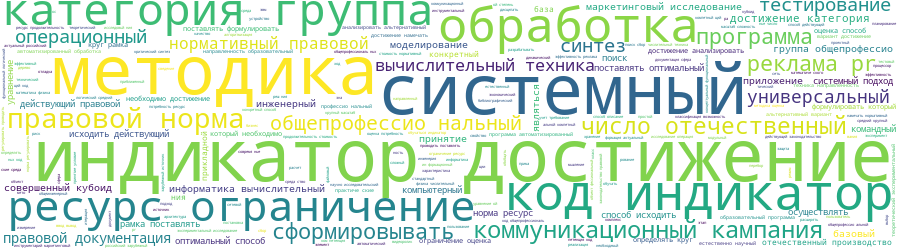

cluster: 14


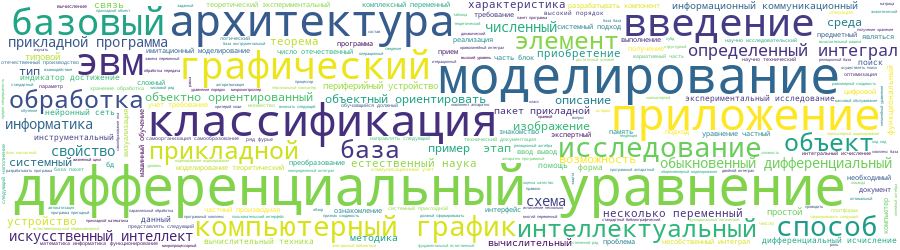

cluster: 15


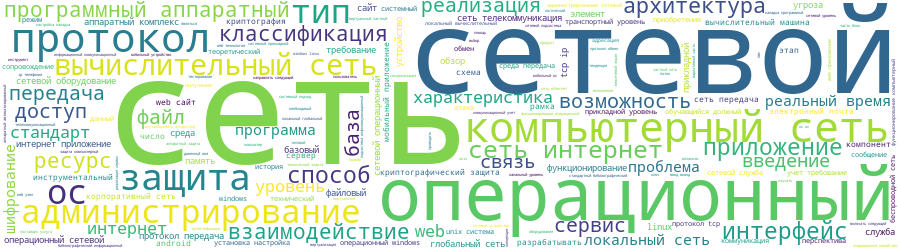

cluster: 16


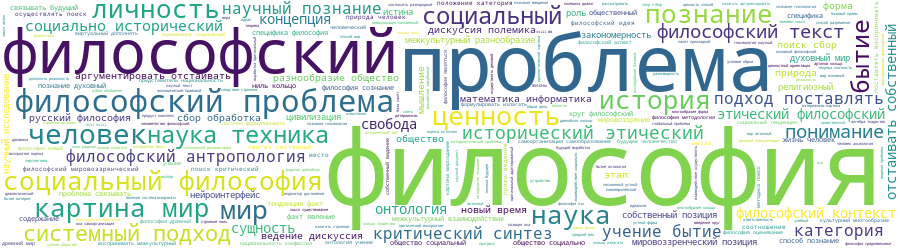

In [60]:
cloud_kwargs = { 'max_words':3000, 'width':900, 'height':250 }
draw_cluster_clouds(df_trunc, labels_lda, n_clusters, alert_by='text', cloud_kwargs=cloud_kwargs)

Из представленных изображений видно, что `LDA` делает хорошее разбиение на кластеры, однако метод чувствителен к данным: необходимая качественная очистка. Могут возникать неинтерпретируемые кластеры, их выявление в большой степени зависит от гиперпараметров.

Тем не менее, оптимальное число кластеров для нашей выборки находится в промежутке от 8 до 16 единиц. Меньшее число кластеров позволяет определять общую направленность. Экстремально малое число кластеров влечет за собой потерю обобщения. Чтобы показать это, запустим `LDA` на малом числе кластеров и вместо содержания текстов будем выводить названия учебных дисциплин (только для визуализации).

cluster: 1


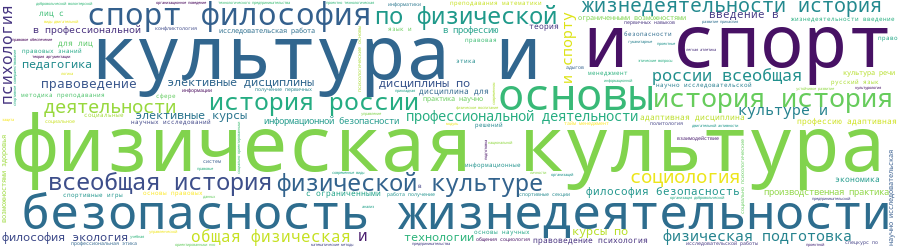

cluster: 2


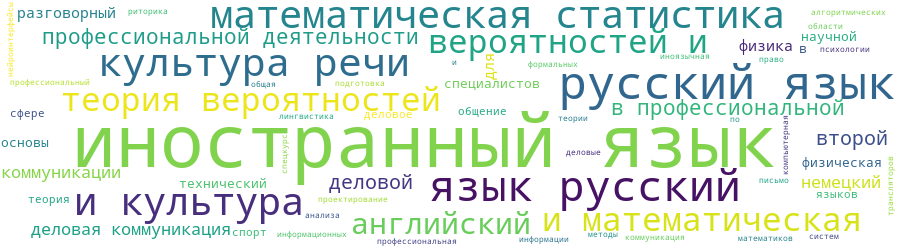

cluster: 3


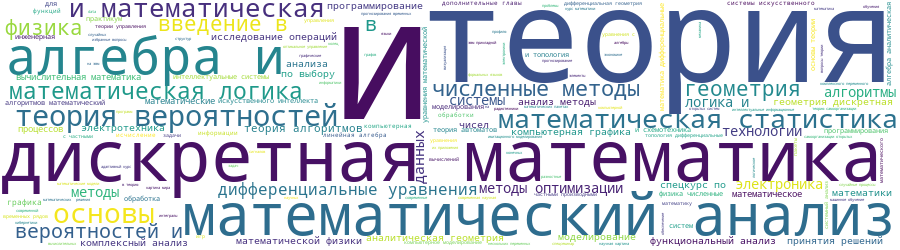

cluster: 4


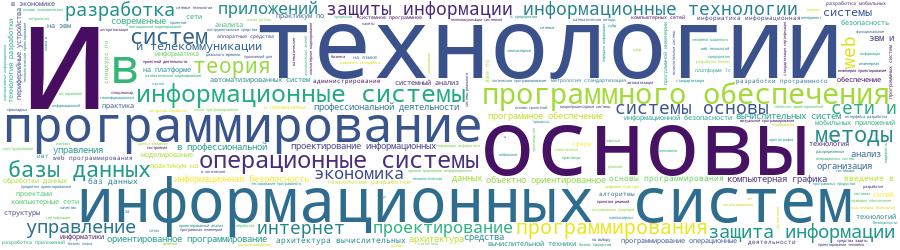

In [389]:
n_clusters = 4
tmp_lda_kwargs = lda_kwargs.copy()
tmp_lda_kwargs['n_components'] = n_clusters

lda_ = LDA(**tmp_lda_kwargs, n_jobs=-1).fit(bow)
labels_lda_ = np.argmax(lda_.transform(bow), axis=1)
cloud_kwargs = { 'max_words':3000, 'width':900, 'height':250 }
draw_cluster_clouds(df_trunc, labels_lda_, n_clusters, alert_by='name', cloud_kwargs=cloud_kwargs)

Удалось выделить следующие кластеры:
* Кластер 1: общеобразовательные и гуманитарные предметы по типу физкультуры, БЖД, истории, правоведения, а также практики;
* Кластер 2: лингвистические курсы, теория вероятностей и математическая статистки (что кажется странным);
* Кластер 3: математика и теоретическая информатика, логика, алгоритмы;
* Кластер 4: практические курсы, включающие в себя информационные технологии, программирование, компьютерную безопасность и др.

Очевидна разница между `LDA` на большом числе кластеров и на малом.

Перейдем к кластеризации на текстовых представлениях.

# Построение представлений

In [21]:
import gensim
from gensim.models import Word2Vec, FastText, Doc2Vec
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = df_trunc.text.tolist()
len(corpus)

2559

### TF-IDF
Рассмотрим разные случаи с разными N-граммами: интересуют юниграммы.

In [25]:
%autoreload 2
from hyperparameters import tfidf_kwargs

X_tfidf_11 = TfidfVectorizer(**tfidf_kwargs).fit_transform(corpus)
X_tfidf_11.shape

(2559, 6312)

### Word2Vec
Модель `Word2Vec` имеет две вариации: `CBOW` и `skip-gramm`. `CBOW` быстрее обучается и хорошо работает на частых словах; `skip-gramm` хорошо себя показывает на малом объеме данных и лучше работает для редкостречаемых слов. Имеет смысл проверить обе модели на нашем наборе данных.

Статья: [T. Mikolov et al. Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/pdf/1301.3781.pdf)\
Статья: [T. Mikolov et al. Distributed Representations of Words and Phrases and their Compositionality](https://arxiv.org/abs/1310.4546)

В теории для нашей задача можно использовать предобученную модель `word2vec-ruscorpora-300` для русского языка, но в ее словаре нет составных слов (web-разработка, http-запрос и др.), поэтому необходимо обучить свои представления, так как такие слова способны хорошо характеризовать документ -- ведь они фактически являются профессиональными терминами.

In [26]:
%autoreload 2
from hyperparameters import w2v_kwargs

corpus_splitted = [text.split() for text in corpus]
w2v_vec_skip = Word2Vec(**w2v_kwargs, sg=1, hs=0)
w2v_vec_cbow = Word2Vec(**w2v_kwargs, sg=0, hs=1, cbow_mean=1)

w2v_vec_skip.build_vocab(corpus_splitted)
w2v_vec_cbow.build_vocab(corpus_splitted)

w2v_vec_skip.train(corpus_splitted, total_examples=w2v_vec_skip.corpus_count, epochs=w2v_vec_skip.epochs)
w2v_vec_cbow.train(corpus_splitted, total_examples=w2v_vec_cbow.corpus_count, epochs=w2v_vec_cbow.epochs)

(5058231, 5184870)

Теперь нужно построить эмбеддинги текстов. Для этого мы используем усреднее на IDF-взвешивании, благодаря чему важные слова будут иметь больший вес для итогового представления.

In [27]:
from collections import defaultdict
from scipy.sparse.csr import csr_matrix
    
class idf_mean_vectorizer(object):
    def __init__(self, word2vec_dict):
        self.word2vec = word2vec_dict
        self.word2weight = None
        self.dim = len(next(iter(word2vec_dict.values())))

    def fit(self, corpus: list):
        tfidf = TfidfVectorizer(**tfidf_kwargs).fit(corpus)
        max_idf = np.max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, corpus):
        corpus_splitted = [text.split() for text in corpus]
        return csr_matrix([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in corpus_splitted
            ])
    
    def fit_transform(self, corpus: list):
        self = self.fit(corpus)
        return self.transform(corpus)

In [28]:
w2v_skip_dict = dict(zip(w2v_vec_skip.wv.index_to_key, w2v_vec_skip.wv.vectors))
w2v_cbow_dict = dict(zip(w2v_vec_cbow.wv.index_to_key, w2v_vec_cbow.wv.vectors))

X_skip_idf = idf_mean_vectorizer(w2v_skip_dict).fit_transform(corpus)
X_cbow_idf = idf_mean_vectorizer(w2v_cbow_dict).fit_transform(corpus)

X_skip_idf.shape, X_cbow_idf.shape

((2559, 1500), (2559, 1500))

### Doc2Vec
В отличие от `Word2Vec`, `Doc2Vec` модели позволяет строить эмбеддинги не для отдельных слов, а сразу для текстов. Данный подход считается более продвинутым методом построения представлений для текстов, чем IDF-усреднение на word2vec-представлениях. Рассматриваемые в оригинальной статье методы `PV-DM` и `PV-DBOW` мы ''конкатенируем'' по совету авторов.

* Гайд: [medium](https://medium.com/wisio/a-gentle-introduction-to-doc2vec-db3e8c0cce5e)
* Ноутбук: [colab](https://colab.research.google.com/github/alvinntnu/python-notes/blob/master/nlp/doc2vec.ipynb#scrollTo=f7mZT30kI1OA)
* Еще что-то: [тык](https://www.machinelearningmastery.ru/another-twitter-sentiment-analysis-with-python-part-6-doc2vec-603f11832504/)

In [29]:
%autoreload 2
from hyperparameters import d2v_kwargs
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

tagged_corpus = [TaggedDocument(doc, [i]) for i, doc in enumerate(corpus_splitted)]

d2v_vec_dbow = Doc2Vec(**d2v_kwargs, dm=0, hs=1, dbow_words=1)
d2v_vec_dm = Doc2Vec(**d2v_kwargs, dm=1, hs=0, dm_mean=1)

d2v_vec_dbow.build_vocab(tagged_corpus)
d2v_vec_dm.reset_from(d2v_vec_dbow)

d2v_vec_dm.train(tagged_corpus, total_examples=d2v_vec_dm.corpus_count, epochs=d2v_vec_dm.epochs)
d2v_vec_dbow.train(tagged_corpus, total_examples=d2v_vec_dbow.corpus_count, epochs=d2v_vec_dbow.epochs)

[Интересный ответ по поводу слеивания](https://stackoverflow.com/questions/69752514/gensim-concatenateddoc2vec-modulenotfounderror-no-module-named-testfixtures)

In [30]:
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec

def build_embedding(model, corpus_splitted):
    matrix = []
    for text_splitted in tqdm(corpus_splitted):
        vector = model.infer_vector(text_splitted)
        matrix.append(vector)
    return csr_matrix(np.asarray(matrix))

d2v_model = ConcatenatedDoc2Vec((d2v_vec_dbow, d2v_vec_dm))
X_d2v = build_embedding(d2v_model, corpus_splitted)
X_d2v.shape

  0%|          | 0/2559 [00:00<?, ?it/s]

(2559, 3000)

Таким образом, мы имеем следующие представления текстов: `TF-IDF` для юниграмм; IDF-усредненные word2vec-эмбеддинги для методов `skip-gram` и `CBOW`; doc2vec-эмбеддинги для методов `PD-DM` + `PV-DBOW`.

In [31]:
data = {
    'TF-IDF':X_tfidf_11,
    'IDF-w. skip-gram':X_skip_idf,
    'IDF-w. CBOW':X_cbow_idf,
    'DBOW + DM':X_d2v,
}

# Визуализация данных

Для визуализации результатов кластеризации мы используем `t-SNE` -- технику нелинейного снижения размерности и визуализации многомерных переменных. Обучим модель на всех представлениях.

In [79]:
%autoreload 2
from hyperparameters import tsne_kwargs
from sklearn.manifold import TSNE
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

data_tsne = {}
for key, X in tqdm(data.items()):
    X_embedded = TSNE(**tsne_kwargs, n_jobs=-1).fit_transform(X.A)
    data_tsne[key] = X_embedded

  0%|          | 0/4 [00:00<?, ?it/s]

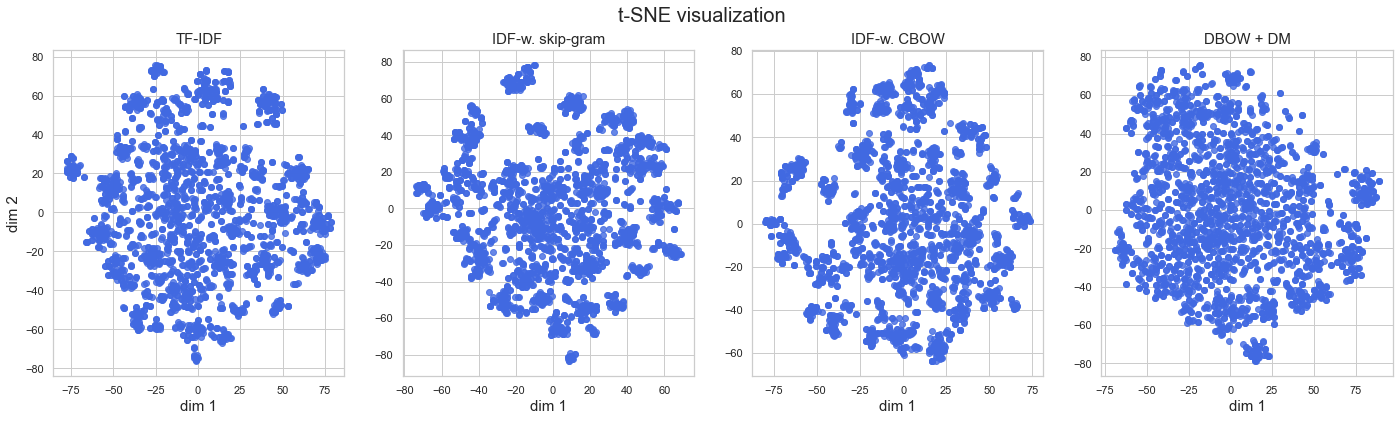

In [80]:
%autoreload 2
from visualization import plot_data_embs
plot_data_embs(data_tsne, title='t-SNE visualization')

Полученные представления, хоть они не являются точный моделью исходных эмбеддингом, тем не менее позволяют визуально различать некоторые кластеры (кроме визуализации Doc2Vec эмбеддингов). Примечательно, что визуализации для методов skip-gram и CBOW идентичны, и визуально отличаются поворотом на 90 градусов.

# Кластеризация

Изначально планировалось выбрать следующие алгоритмы кластеризации: `DBSCAN`, спектральный и `OPTICS`. Из визуализации данных (и пробных попыток) стало очевидно, что `DBSCAN` и `OPTICS` не подходят для данной задачи -- они показывают посредственные результаты на плотных данных. Следует использовать алгоритмы, которые хорошо работают на таких представлениях. В результате мы рассматриваем другие алгоритмы кластеризации: `KMeans`, спектральный, смесь гауссиан. 

Метод спектральной кластеризации хорошо работает на большом разнообразии геометрии кластеров ([источник](https://scikit-learn.org/stable/modules/clustering.html#)), умеет определять вложенные кластеры, однако является трансдуктивным (т.е. не способен работать с новыми данными). Смесь гауссиан хорошо работает с плоской геометрией, подходит для плотных данных (как в случае с d2v), но абсолютно не масштабируема. Алгоритм `KMeans` является универсальным, хорошо подходит для среднего числа кластеров.

In [202]:
def cluster_fitting(name, kwargs: list, data_embs=data, verbose=False, sparse=True):
    if len(kwargs) != 1:
        assert len(kwargs) == len(data_tsne)
        
    if name == 'KMeans':
        model = KMeans
    elif name == 'GaussianMixture':
        model = GaussianMixture
    elif name == 'SpectralClustering':
        model = SpectralClustering
    else:
        raise ValueError('Unknows clustering algorithm!')
        
    labels_list, alg_list = [], []
    for i, (key, X) in enumerate(tqdm(data_embs.items())):
        if len(kwargs) == 1:
            i = -1
        if sparse:
            alg = model(**kwargs[i]).fit(X.A)
        else:
            alg = model(**kwargs[i]).fit(X)
        
        alg_list += [alg]
        try:
            labels = alg.labels_
        except:
            if sparse:
                labels = alg.predict(X.A)
            else:
                labels = alg.predict(X)
        labels_list += [labels]
        
        if verbose:
            n_clusters = len(np.unique(labels_list[-1]))
            print('n_clusters for {}:'.format(key),  n_clusters)
        
    return labels_list, alg_list

### KMeans

In [216]:
%autoreload 2
from hyperparameters import kmeans_kwargs
from sklearn.cluster import KMeans

labels_km, algs_km = cluster_fitting('KMeans', kmeans_kwargs, data_embs=data, verbose=True)

lbs = dict(zip(data_tsne.keys(), labels_km))

  0%|          | 0/4 [00:00<?, ?it/s]

n_clusters for TF-IDF: 16
n_clusters for IDF-w. skip-gram: 16
n_clusters for IDF-w. CBOW: 16
n_clusters for DBOW + DM: 16


### Смесь гауссиан

In [390]:
%autoreload 2
from hyperparameters import gm_kwargs
from sklearn.mixture import GaussianMixture

labels_gm, algs_gm = cluster_fitting('GaussianMixture', gm_kwargs, data_embs=data, verbose=True)

lbs = dict(zip(data_tsne.keys(), labels_gm))

  0%|          | 0/4 [00:00<?, ?it/s]

n_clusters for TF-IDF: 16
n_clusters for IDF-w. skip-gram: 16
n_clusters for IDF-w. CBOW: 16
n_clusters for DBOW + DM: 16


### Спектральная кластеризация

In [384]:
%autoreload 2
from hyperparameters import spectral_kwargs
from sklearn.cluster import SpectralClustering

labels_sc, algs_sc = cluster_fitting('SpectralClustering', spectral_kwargs, data_embs=data, verbose=True)

  0%|          | 0/4 [00:00<?, ?it/s]

n_clusters for TF-IDF: 16
n_clusters for IDF-w. skip-gram: 16
n_clusters for IDF-w. CBOW: 16
n_clusters for DBOW + DM: 16


# Визуализация
К визуализации алгоритмов кластеризации добавим `LDA`: метод хорошо распределил объекты по темам, поэтому визуализации `LDA` можно визуально определить, адекватны ли визуализации других алгоритмов.

Отметим, что `LDA` работает с мешком слов, а не на числовых представлениях текстов, благодаря чему можно использовать одни и те же метки на разных эмбеддингах.

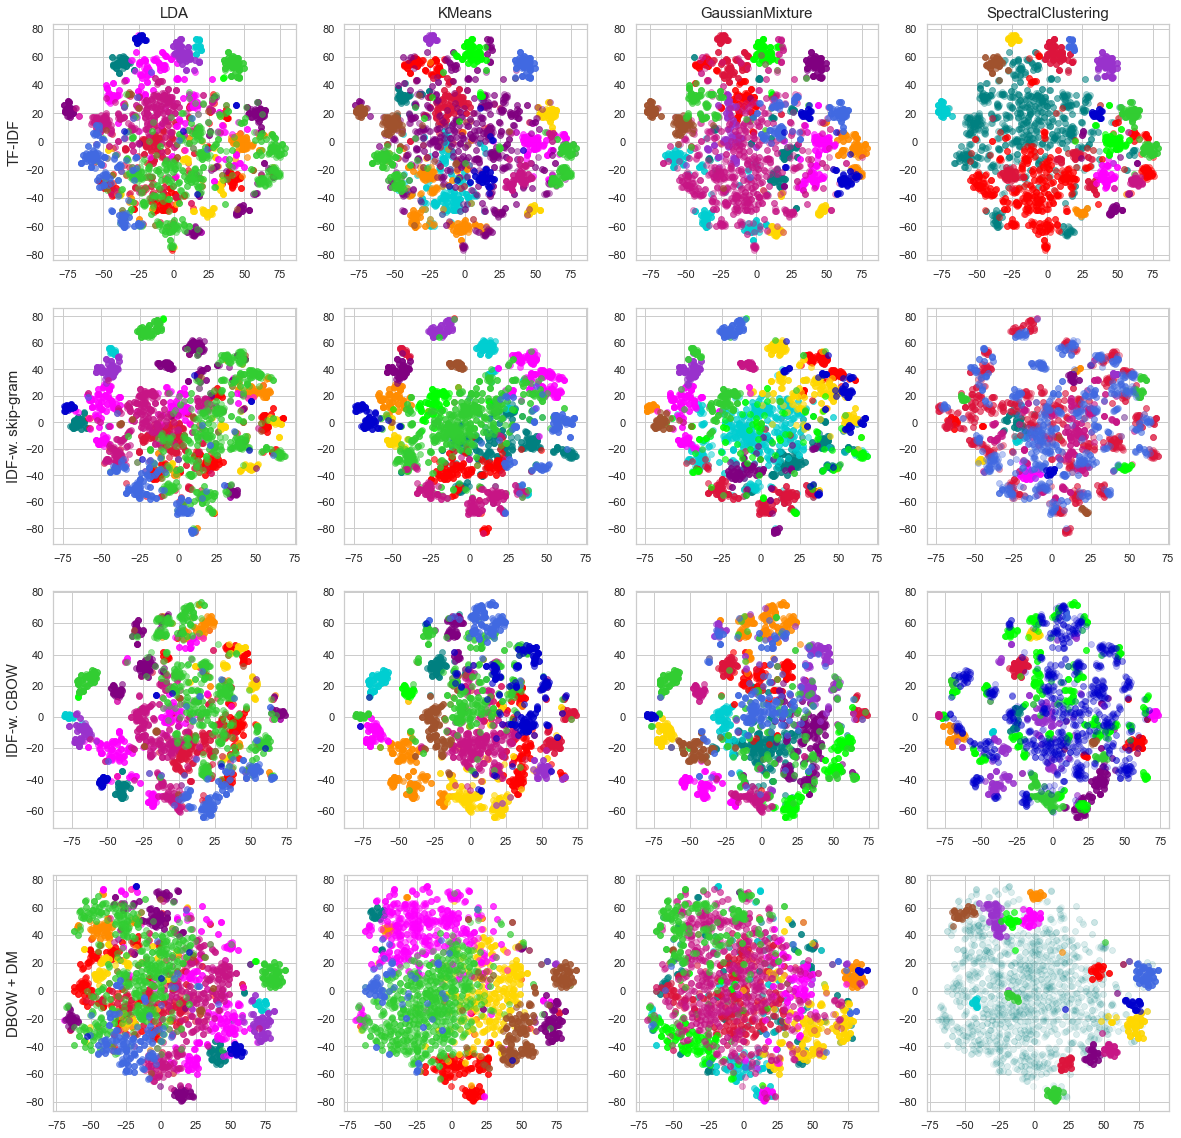

In [391]:
%autoreload 2
from visualization import plot_clustering

lbs = [
    dict(zip(data_tsne.keys(), [labels_lda for i in range(4)])),
    dict(zip(data_tsne.keys(), labels_km)),
    dict(zip(data_tsne.keys(), labels_gm)),
    dict(zip(data_tsne.keys(), labels_sc)),
]

plot_clustering(16, data_tsne, lbs, ['LDA', 'KMeans', 'GaussianMixture', 'SpectralClustering'],
                list(data_tsne.keys()), title='')

In [242]:
# for i in range(16):
#     inds = np.argwhere(labels_km[3] == i).reshape((-1,))
#     print('n for {} cluster: {}'.format(i + 1, len(inds)))